# Import

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from dateutil import parser
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier as EEC
from imblearn.ensemble import RUSBoostClassifier as RUSBoost


# Load Dataset

In [2]:
#Original data set
data_original_train = pd.read_csv("train_auto.csv", index_col=None)
data_original_test = pd.read_csv("test_auto.csv", index_col=None)

pd.options.display.max_columns = 50
pd.set_option('display.max_rows', 50)

#Extract the labels of the train dataset
# y = data_original_train['label'].to_numpy()

In [3]:
data_original_train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
data_original_train.shape

(8161, 26)

In [5]:
data_original_test.shape

(2141, 26)

In [6]:
##### categorical data:
# KIDSDRIV(01234), 
# HOMEKIDS (012345)
# PARENT1 (yes no)
# MSTATUS（yes no）
# SEX（z_F, M）
# EDUCATION(z_High School:2330; Bachelors:2242; Masters:1658; <High School:1203; PhD:728)
# JOB (z_Blue Collar:1825; Clerical: 1271; Professional:1117; Manager: 988; Lawyer: 835; Student:712; Home Maker:641; Doctor :46)
# CAR_USE（private/commercial）
# CAR_TYPE (z_SUV:2294; Minivan:2145; Pickup:1389; Sports Car: 907; Van:750; Panel Truck:676)
# RED_CAR（yes/no）
# CLM_FREQ (0-5)
# REVOKED (yes/no)
# URBANICITY (urban/ rural)


###### numerical data:
# TARGET_AMT（6008 of 0, otherwise all big numbers）； 
# AGE 46- 80
# YOJ (0-23)
# INCOME 
# HOME_VAL（2000 of 0）
# TRAVTIME（integer）
# BLUEBOOK
# TIF （1-25）
# OLDCLAIM (5009 of 0)
# MVR_PTS (integer; 0-13)
# CAR_AGE (-3 ~28)

In [8]:
data_original_train.dtypes

INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object

# Clean Datas

### Convert 'fake string' columns to float

We removed the '$' symbol, replaced ',' by '.' and set the 'nan' to real np.nan so all the datas could be interpreted and converted to float

In [9]:
for field in ['OLDCLAIM', 'HOME_VAL', 'BLUEBOOK', 'INCOME']:
    data_original_train[field] = data_original_train[field].astype(str).apply(lambda x : x.replace(',', '.')[1:]).replace('an', np.nan).astype(float)

In [10]:
for field in ['OLDCLAIM', 'HOME_VAL', 'BLUEBOOK', 'INCOME']:
    data_original_test[field] = data_original_test[field].astype(str).apply(lambda x : x.replace(',', '.')[1:]).replace('an', np.nan).astype(float)

### Encode string columns using one-hot-encoder

This can be costly in term of memory, we will first try to encode every categorical columns. If we face memory issue when running our Classification algorithm we will drop some columns

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse = False)

In [12]:
data_original_train = pd.get_dummies(data_original_train)

In [13]:
data_original_test = pd.get_dummies(data_original_test)

### Handling missing values

As sklearn implementation of Random Forest and other ML algorithms doesn't take automatically take care of missing values, we will have to handle missing values before implementing any ML algorithm.

In [14]:
data_original_train.isna().sum()

INDEX                                 0
TARGET_FLAG                           0
TARGET_AMT                            0
KIDSDRIV                              0
AGE                                   6
HOMEKIDS                              0
YOJ                                 454
INCOME                              445
HOME_VAL                            464
TRAVTIME                              0
BLUEBOOK                              0
TIF                                   0
OLDCLAIM                              0
CLM_FREQ                              0
MVR_PTS                               0
CAR_AGE                             510
PARENT1_No                            0
PARENT1_Yes                           0
MSTATUS_Yes                           0
MSTATUS_z_No                          0
SEX_M                                 0
SEX_z_F                               0
EDUCATION_<High School                0
EDUCATION_Bachelors                   0
EDUCATION_Masters                     0


In [15]:
data_original_train.isna().sum().sum()

1879

The above output shows us that between 510 and 1879 rows contain missing values, which correspond to 6% to 23% of the datas. This being a significant proportion of the dataset we cannot afford to delete the concerned rows and thus have to find and ad-hoc solution for each field containing missing values.

- AGE/YOJ

From our understanding of the different features, interpolating this feature from the other features would not be sufficiently relevant. 

We choose then to fill nan values with the median of ages

In [16]:
data_original_train['AGE'] = data_original_train['AGE'].replace(np.nan, data_original_train.AGE.median())
data_original_train['YOJ'] = data_original_train['YOJ'].replace(np.nan, data_original_train.YOJ.median())

In [17]:
data_original_test['AGE'] = data_original_test['AGE'].replace(np.nan, data_original_test.AGE.median())
data_original_test['YOJ'] = data_original_test['YOJ'].replace(np.nan, data_original_test.YOJ.median())

- INCOME/HOME_VAL/CAR_AGE

From our understanding of the different features, interpolating theses features is relevant. 

We choose then to use the pandas interpolate method.

In [18]:
data_original_train = data_original_train.interpolate(method='linear')

In [19]:
data_original_test = data_original_test.interpolate(method='linear')

### TARGET_AMT

This field is entirely nan in the test set, as it has 'TARGET' in its name we can induce that it is entirely dependant on the other variable thus independant from TARGET_FLAG, we choose then to train our model on the dataset excluidng the TARGET_AMT field.


# Feature importance and choice

This part is for me to understand the importance of features, I used mutual information to find the most relevant features for the classification task.

In [22]:
'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Set a random state for reproducible results
np.random.seed(18)

fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train)

from matplotlib import pyplot

# plot the top 10 scores
nb_best = 10
fs.scores_[::-1].sort() # Sort scores in descending order
pyplot.figure(figsize=(10,8))
pyplot.bar([i for i in range(nb_best)], fs.scores_[:nb_best])
pyplot.xlabel('Top 10 features')
pyplot.ylabel('Score')
pyplot.title('Top 10 importance scores based on mutual information')
pyplot.show()
'''

"\nfrom sklearn.feature_selection import SelectKBest\nfrom sklearn.feature_selection import mutual_info_classif\n\n# Set a random state for reproducible results\nnp.random.seed(18)\n\nfs = SelectKBest(score_func=mutual_info_classif, k='all')\nfs.fit(X_train, y_train)\n\nfrom matplotlib import pyplot\n\n# plot the top 10 scores\nnb_best = 10\nfs.scores_[::-1].sort() # Sort scores in descending order\npyplot.figure(figsize=(10,8))\npyplot.bar([i for i in range(nb_best)], fs.scores_[:nb_best])\npyplot.xlabel('Top 10 features')\npyplot.ylabel('Score')\npyplot.title('Top 10 importance scores based on mutual information')\npyplot.show()\n"

In [23]:
from sklearn.model_selection import train_test_split

X = data_original_train.drop(['TARGET_FLAG', 'TARGET_AMT'], axis = 1)
y = data_original_train['TARGET_FLAG'] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 18)

In [25]:
# Necessary imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

# Baseline Decision tree

In [27]:
# Classifier
clf = DecisionTreeClassifier(random_state = 0)

# Grid search parameters
grid_params = {'criterion':['gini', 'entropy'],
               'splitter':['best', 'random'],
               'max_depth':[1,5,10,15,20,25],
               'min_samples_split': [2,4,6,8],
               'max_features':['auto', 'sqrt', 'log2'],
               'min_samples_leaf': [1,2,3,4],
               'class_weight': [None, 'balanced']
               }

## Grid search

# We use the F1-micro score to choose the best parameters, even though we compute other scoring metrics
gs = GridSearchCV(clf, grid_params, cv=5, scoring= ['accuracy','f1_micro', 'f1_weighted'], refit='f1_micro', n_jobs=-1)
gs.fit(X_train, y_train)

print('\nSet of parameter combinations tested')
print(gs.cv_results_['params'])

print('\nCorresponding scores')
print('Accuracy: ', gs.cv_results_['mean_test_accuracy'])
print('F1_weighted: ', gs.cv_results_['mean_test_f1_weighted'])
print('F1_micro: ', gs.cv_results_['mean_test_f1_micro'])

print('\nBest parameters combination (based on F1_micro score)')
print(gs.best_params_)

print('\nBest F1_micro score')
print(gs.best_score_)

# Test the model on the test set (using the best model based on the F1_micro score)
y_pred = gs.predict(X_val)
print('\nModel performance for the test set, using the best performing model on the F1_micro metric')
print('Accuracy score on the test set: ', accuracy_score(y_val, y_pred))
print('F1_weighted score on the test set: ', f1_score(y_val, y_pred, average='weighted'))
print('F1_micro score on the test set: ', f1_score(y_val, y_pred, average='micro'))

# Confusion matrix
print('\nConfusion matrix on test set:')
print('[0, 1]')
print(confusion_matrix(y_val, y_pred, labels=[0, 1]))
print(classification_report(y_val, y_pred, labels=[0, 1]))


Set of parameter combinations tested
[{'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'splitter': 'best'}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'splitter': 'random'}, {'class_weight': None, 'criterion': 'gini',

# Random Forest

In [28]:
# Classifier
clf = RandomForestClassifier(oob_score=True, random_state=0)

#Grid search parameters
grid_params = {'n_estimators':[50, 100, 200],
               'criterion':['gini', 'entropy'],
               'min_samples_leaf':[1,3],
               'max_depth':[3, 5, 10, 15, 20],
               'max_features':['sqrt', 'log2', 0.65],
               'max_samples':[0.5, 0.7, None]}
## Grid search

# We use the F1-micro score to choose the best parameters, even though we compute other scoring metrics
gs = GridSearchCV(clf, grid_params, cv=5, scoring= ['accuracy','f1_micro', 'f1_weighted'], refit='f1_micro', n_jobs=-1)
gs.fit(X_train, y_train)

print('\nSet of parameter combinations tested')
print(gs.cv_results_['params'])

print('\nCorresponding scores')
print('Accuracy: ', gs.cv_results_['mean_test_accuracy'])
print('F1_weighted: ', gs.cv_results_['mean_test_f1_weighted'])
print('F1_micro: ', gs.cv_results_['mean_test_f1_micro'])

print('\nBest parameters combination (based on F1_micro score)')
print(gs.best_params_)

print('\nBest F1_micro score')
print(gs.best_score_)

# Test the model on the test set (using the best model based on the F1_micro score)
y_pred = gs.predict(X_val)
print('\nModel performance for the test set, using the best performing model on the F1_micro metric')
print('Accuracy score on the test set: ', accuracy_score(y_val, y_pred))
print('F1_weighted score on the test set: ', f1_score(y_val, y_pred, average='weighted'))
print('F1_micro score on the test set: ', f1_score(y_val, y_pred, average='micro'))

# Confusion matrix
print('\nConfusion matrix on test set:')
print('[0, 1]')
print(confusion_matrix(y_val, y_pred, labels=[0, 1]))
print(classification_report(y_val, y_pred, labels=[0, 1]))


Set of parameter combinations tested
[{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 50}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 200}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 50}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 100}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 200}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 1, 'n_estimators': 50}, {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_samples'

# Extremely Randomized Trees

In [29]:
# Classifier
clf = ExtraTreesClassifier(oob_score=True, random_state = 0, bootstrap=True)

# Grid search parameters
grid_params = {'criterion':['gini', 'entropy'],
               'n_estimators':[20, 50, 100, 200],
                  'max_depth':[5, 10, 13, 15, 20],
               'max_features':['sqrt', 'log2', 0.5, 0.65],
               'max_samples':[0.5, 0.6, 0.7, None], 
               'min_samples_leaf': [1, 3]}

## Grid search

# We use the F1-micro score to choose the best parameters, even though we compute other scoring metrics
gs = GridSearchCV(clf, grid_params, cv=5, scoring= ['accuracy','f1_micro', 'f1_weighted'], refit='f1_micro', n_jobs=-1)
gs.fit(X_train, y_train)

print('\nSet of parameter combinations tested')
print(gs.cv_results_['params'])

print('\nCorresponding scores')
print('Accuracy: ', gs.cv_results_['mean_test_accuracy'])
print('F1_weighted: ', gs.cv_results_['mean_test_f1_weighted'])
print('F1_micro: ', gs.cv_results_['mean_test_f1_micro'])

print('\nBest parameters combination (based on F1_micro score)')
print(gs.best_params_)

print('\nBest F1_micro score')
print(gs.best_score_)

# Test the model on the test set (using the best model based on the F1_micro score)
y_pred = gs.predict(X_val)
print('\nModel performance for the test set, using the best performing model on the F1_micro metric')
print('Accuracy score on the test set: ', accuracy_score(y_val, y_pred))
print('F1_weighted score on the test set: ', f1_score(y_val, y_pred, average='weighted'))
print('F1_micro score on the test set: ', f1_score(y_val, y_pred, average='micro'))

# Confusion matrix
print('\nConfusion matrix on test set:')
print('[0, 1]')
print(confusion_matrix(y_val, y_pred, labels=[0, 1]))
print(classification_report(y_val, y_pred, labels=[0, 1]))


Set of parameter combinations tested
[{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 20}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 50}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 200}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 20}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 50}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 100}, {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_samples':

# Adaboost

In [30]:
# Classifier
clf = AdaBoostClassifier()

# Grid search parameters
grid_params = {'base_estimator':[DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=5)],
                'n_estimators':[10, 20, 50, 100, 150, 200],
                'learning_rate': [0.01, 0.05, 0.1, 1]}

## Grid search

# We use the F1-micro score to choose the best parameters, even though we compute other scoring metrics
gs = GridSearchCV(clf, grid_params, cv=5, scoring= ['accuracy','f1_micro', 'f1_weighted'], refit='f1_micro', n_jobs=-1)
gs.fit(X_train, y_train)

print('\nSet of parameter combinations tested')
print(gs.cv_results_['params'])

print('\nCorresponding scores')
print('Accuracy: ', gs.cv_results_['mean_test_accuracy'])
print('F1_weighted: ', gs.cv_results_['mean_test_f1_weighted'])
print('F1_micro: ', gs.cv_results_['mean_test_f1_micro'])

print('\nBest parameters combination (based on F1_micro score)')
print(gs.best_params_)

print('\nBest F1_micro score')
print(gs.best_score_)

# Test the model on the test set (using the best model based on the F1_micro score)
y_pred = gs.predict(X_val)
print('\nModel performance for the test set, using the best performing model on the F1_micro metric')
print('Accuracy score on the test set: ', accuracy_score(y_val, y_pred))
print('F1_weighted score on the test set: ', f1_score(y_val, y_pred, average='weighted'))
print('F1_micro score on the test set: ', f1_score(y_val, y_pred, average='micro'))

# Confusion matrix
print('\nConfusion matrix on test set:')
print('[0, 1]')
print(confusion_matrix(y_val, y_pred, labels=[0, 1]))
print(classification_report(y_val, y_pred, labels=[0, 1]))


Set of parameter combinations tested
[{'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 10}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 20}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 50}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 100}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 150}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 200}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.05, 'n_estimators': 10}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.05, 'n_estimators': 20}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.05, 'n_estimators': 50}, {'base_estimator': DecisionTreeClassifier(max_depth=3), 'l

# Gradient Boost

In [31]:
# Classifier
args = {}
# Classifier
clf = GradientBoostingClassifier(**args, random_state = 0)

# Grid search parameters
grid_params = {
               'max_depth':[4, 5],
               'min_samples_split': [2,4],
               'min_samples_leaf': [1,2,4],
               'max_features': [0.5, 0.75]
               }

## Grid search

# We use the F1-micro score to choose the best parameters, even though we compute other scoring metrics
gs = GridSearchCV(clf, grid_params, cv=5, scoring= ['accuracy','f1_micro', 'f1_weighted'], refit='f1_micro', n_jobs=-1)
gs.fit(X_train, y_train)

print('\nSet of parameter combinations tested')
print(gs.cv_results_['params'])

print('\nCorresponding scores')
print('Accuracy: ', gs.cv_results_['mean_test_accuracy'])
print('F1_weighted: ', gs.cv_results_['mean_test_f1_weighted'])
print('F1_micro: ', gs.cv_results_['mean_test_f1_micro'])

print('\nBest parameters combination (based on F1_micro score)')
print(gs.best_params_)

print('\nBest F1_micro score')
print(gs.best_score_)

# Test the model on the test set (using the best model based on the F1_micro score)
y_pred = gs.predict(X_val)
print('\nModel performance for the test set, using the best performing model on the F1_micro metric')
print('Accuracy score on the test set: ', accuracy_score(y_val, y_pred))
print('F1_weighted score on the test set: ', f1_score(y_val, y_pred, average='weighted'))
print('F1_micro score on the test set: ', f1_score(y_val, y_pred, average='micro'))

# Confusion matrix
print('\nConfusion matrix on test set:')
print('[0, 1]')
print(confusion_matrix(y_val, y_pred, labels=[0, 1]))
print(classification_report(y_val, y_pred, labels=[0, 1]))



Set of parameter combinations tested
[{'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2}, {'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 4}, {'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2}, {'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 4}, {'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 2}, {'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 4}, {'max_depth': 4, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 2}, {'max_depth': 4, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 4}, {'max_depth': 4, 'max_features': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 2}, {'max_depth': 4, 'max_features': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 4}, {'max_depth': 4, 'max_features': 0.75, 'min_samples_leaf': 4, 'min_samples_split': 2}, {'max_dept

# Dealing with unbalanced dataset:
As we noticed that, even with different grid searches on different models, the performance is not yet satisfied as we expected, the reason lies in the * unbalanced dataset *

We can use Easy Ensemble/Random Under Sampling to deal with easily.


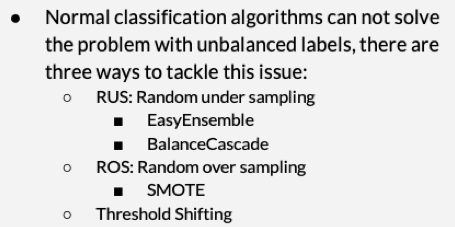

# Generate Output for our test dateset

In [21]:
X_test = data_original_test.drop(columns = ['TARGET_FLAG', 'TARGET_AMT'])

Y_test = clf.predict(X_test)
